In [1]:
from sklearn import ensemble, cross_validation, learning_curve, metrics
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import GroupKFold

from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from scipy.stats.kde import gaussian_kde
from scipy.optimize import brentq

import itertools

C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are mov

In [2]:
triplexes = pd.read_csv('basetriples_bal3.csv', header=0, sep='\t')

In [3]:
triplexes.head()

,pdb_chain,type,dssrs,bps,dists,same12,local12,longrange12,same23,local23,...,h3p5,b3p5,i3p5,j3p5,lc3p5,li3p5,lp3p5,fl3p5,fed3p5,istriple
0,1b23.cif1_R,0,R.A.58.R.C.59.R.C.62.,-_-_-,7.44_14.99_11.32,1,0,0,0,1,...,0,0,0,0,0,0,0,7,1,0
1,1b23.cif1_R,110,R.A.9.R.A.22.R.C.44.,-_-_-,13.84_18.91_7.57,0,0,1,0,0,...,0,0,0,0,0,0,0,5,1,0
2,1b23.cif1_R,112,R.4SU.8.R.A.14.R.G.15.,tWH_-_-,10.04_5.15_12.32,0,0,1,1,0,...,1,0,0,0,1,0,0,9,1,0
3,1b23.cif1_R,123,R.A.9.R.G.15.R.A.46.,-_-_-,16.53_14.44_4.24,0,0,1,0,0,...,0,0,0,0,0,0,0,5,1,0
4,1b23.cif1_R,120,R.G.15.R.A.46.R.U.60.,-_-_-,14.44_13.48_10.24,0,0,1,0,0,...,0,0,0,0,0,0,0,5,0,0


In [4]:
triplexes.shape

(10767, 477)

In [5]:
### !!!!! необходимые данные

triplexes_data = triplexes.iloc[:, 5:475]
triplexes_target = triplexes.iloc[:, 476]

In [6]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap="YlGnBu"):  #"YlGnBu" plt.cm.gray_r
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    print("CONFUSION MATRIX")
    print(df_confusion)
    a = itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1]))
    for i, j in itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1])):
        if i == 2:
            i_ = 'All'
        else:
            i_ = i
        if j == 2:
            j_ = 'All'
        else:
            j_ = j
        plt.text(i, j, df_confusion[i_][j_], horizontalalignment="center", color='black')
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()
    
    
    
def probability_density(y_prob, y):
    kde1 = gaussian_kde(y_prob[y == 1])
    kde2 = gaussian_kde(y_prob[y == 0])
    
    x1 = np.linspace(np.min(y_prob[y == 1]),np.max(y_prob[y == 1]),500)
    x2 = np.linspace(np.min(y_prob[y == 0]),np.max(y_prob[y == 0]),500)
    
    try:
        treshold = brentq(lambda x : kde1(x) - kde2(x), x2[np.argmax(kde1(x1))], x1[np.argmax(kde2(x2))])
    except ValueError:
        treshold = 0.5
        
    plt.fill_between(x1,kde1(x1),0, color='darkblue', alpha = 0.5, label = 'Triplexes')
    plt.fill_between(x2,kde2(x2), 0, color='darkgrey', alpha = 0.5, label = 'Non-triplexes')
    plt.axvline(x1[np.argmax(kde1(x1))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(x2[np.argmax(kde2(x2))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(treshold, color='black', linestyle='-.', alpha = 0.7, label = str(round(treshold,2)))
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title('Probability Distributions')
    plt.xlabel('Probabilities')
    plt.show()


In [7]:
#используемая модель
rf_classifier_cv = ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=1)

TEST_GROUPS Counter({'3j7q.cif1_5': 379, '3j79.cif1_A': 282, '3j7p.cif1_S2': 224, '4v88.cif1_A6': 187, '5o5j.cif1_A': 166, '6gaw.cif1_BA': 161, '6az3.cif1_1': 116, '3j9m.cif1_AA': 93, '5oql.cif1_1': 46, '5j7l.cif1_DB': 21, '5t5h.cif1_D': 21, '4gxy.cif1_A': 20, '5xy3.cif1_3': 19, '4ioa.cif1_Y': 18, '5xxb.cif1_3': 17, '3mxh.cif1_R': 16, '1c0a.cif1_B': 15, '3ndb.cif1_M': 11, '4uyk.cif1_R': 11, '2qus.cif1_A': 10, '2xdb.cif1_G': 10, '3d2v.cif1_A': 10, '4qei.cif1_C': 10, '6az3.cif1_4': 10, '6gaw.cif1_BB': 10, '3d0u.cif1_A': 9, '3g9c.cif1_Q': 9, '3npq.cif1_A': 9, '4jf2.cif1_A': 9, '4jrc.cif1_B': 9, '4p5j.cif1_A': 9, '4y1m.cif1_B': 9, '5hr7.cif1_D': 9, '5lzs.cif1_3': 9, '5mrc.cif1_bb': 9, '5oql.cif1_2': 9, '1i6u.cif1_C': 8, '1mms.cif1_C': 8, '1u0b.cif1_A': 8, '3ivn.cif1_A': 8, '3j7q.cif1_8': 8, '4m4o.cif1_B': 8, '5b63.cif1_D': 8, '1et4.cif1_A': 7, '4ato.cif1_G': 7, '4fen.cif1_B': 7, '4wfl.cif1_A': 7, '5t5h.cif1_H': 7, '1f7u.cif1_B': 6, '2zzn.cif1_D': 6, '6d90.cif1_3': 6, '1s03.cif1_B': 5, '4lc

[[11  1]
 [ 0  9]]

100 B.G.14.B.C.15.B.C.35. -_-_- 5.19_53.28_57.38 PROBA:  0.5105870820640369
CONFUSION MATRIX By chain:  1kuq.cif1_B
[[1 1]
 [0 1]]

0 S2.A.1369.S2.G.1611.S2.C.1627. -_-_- 66.93_14.17_57.55 PROBA:  0.6329183838136355
110 S2.A.149.S2.C.490.S2.G.510. -_cWW_- 40.24_10.49_41.46 PROBA:  0.5641747434080212
110 S2.C.1557.S2.G.1577.S2.A.1579. -_cSW_- 16.99_6.38_19.56 PROBA:  0.5759150951055299
112 S2.C.750.S2.A.1287.S2.G.1312. -_tHS_- 159.02_9.34_164.46 PROBA:  0.6066896969670623
111 S2.G.10.S2.U.1201.S2.A.1697. cWW_cWW_- 11.68_13.43_5.54 PROBA:  0.25273817901676027
111 S2.C.35.S2.A.520.S2.A.825. cWW_cSS_- 9.93_5.49_12.49 PROBA:  0.4312697204907746
111 S2.A.91.S2.A.92.S2.U.443. cHW_tHW_- 8.03_12.08_12.28 PROBA:  0.1817753158370217
111 S2.A.111.S2.C.350.S2.G.383. cWW_tSW_- 10.19_8.4_12.65 PROBA:  0.4006528577196125
111 S2.G.114.S2.G.380.S2.C.382. -_tSH_cSS 12.57_7.64_5.56 PROBA:  0.4260171065486753
111 S2.A.664.S2.A.670.S2.C.1163. tSW_-_cWW 8.35_6.84_10.16 PROBA:  0.436164610

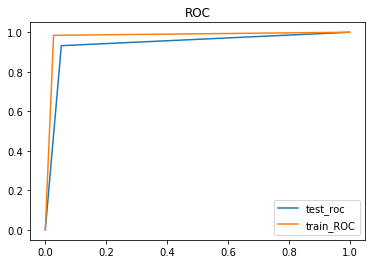

Probability density for train


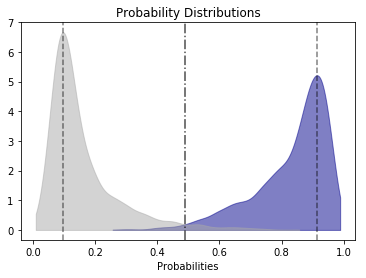

Probability density for test


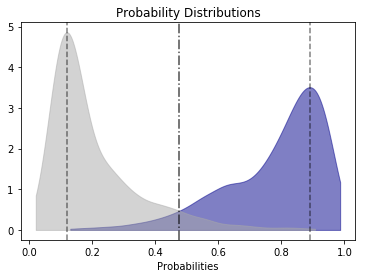


[[1079   60]
 [  69  946]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1079    60  1139
1            69   946  1015
All        1148  1006  2154


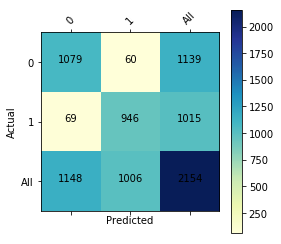


REPORT
             precision    recall  f1-score   support

          0       0.94      0.95      0.94      1139
          1       0.94      0.93      0.94      1015

avg / total       0.94      0.94      0.94      2154

ACCURACY =  0.9401114206128134
-----------------
TEST_GROUPS Counter({'4v9f.cif1_0': 333, '4ioa.cif1_X': 285, '5mrc.cif1_A': 239, '5xy3.cif1_1': 223, '6ek0.cif1_S2': 163, '3j7a.cif1_A': 140, '5xyi.cif1_2': 127, '6d9j.cif1_2': 114, '4p95.cif1_A': 26, '1nbs.cif1_B': 22, '4v9f.cif1_9': 21, '3pdr.cif1_X': 20, '5xym.cif1_B': 19, '6ha1.cif1_B': 18, '4oqu.cif1_A': 17, '5lys.cif1_B': 16, '4qk8.cif1_A': 15, '5nwq.cif1_A': 12, '3v7e.cif1_C': 11, '1qf6.cif1_B': 10, '4prf.cif1_B': 10, '4yco.cif1_D': 10, '5t83.cif1_A': 10, '6cb3.cif1_B': 10, '6d9j.cif1_8': 10, '1fir.cif1_A': 9, '1gax.cif1_D': 9, '2csx.cif1_C': 9, '3wfs.cif1_A': 9, '4lvw.cif1_A': 9, '4rzd.cif1_A': 9, '4xnr.cif1_X': 9, '4yye.cif1_C': 9, '5u3g.cif1_B': 9, '6az3.cif1_5': 9, '6ek0.cif1_L8': 9, '2gdi.cif1_X': 8, '3amu.

111 2.U.12.2.A.1199.2.G.1356. cWW_-_cSS 10.72_12.19_3.87 PROBA:  0.3857324184770212
111 2.A.46.2.U.97.2.G.434. cHS_cWW_- 7.57_9.91_9.63 PROBA:  0.18662327846156135
111 2.U.115.2.A.349.2.C.381. cWW_-_cSW 9.52_11.39_5.87 PROBA:  0.49657229307159134
111 2.U.361.2.U.1174.2.G.1187. cWW_cWS_- 8.84_8.81_7.66 PROBA:  0.467083606162904
111 2.G.1037.2.C.1078.2.A.1181. cWW_tSW_cSW 10.46_9.7_9.34 PROBA:  0.4857331620655769
111 2.C.1273.2.G.1324.2.A.1508. -_tSW_tWH 11.85_9.68_10.26 PROBA:  0.44638701661051755
CONFUSION MATRIX By chain:  6d9j.cif1_2
[[59  0]
 [ 6 49]]

110 S2.G.845.S2.U.1653.S2.G.1671. -_cWW_- 138.78_10.6_135.46 PROBA:  0.585165947555282
111 S2.C.35.S2.A.520.S2.A.825. cWW_cSW_- 10.39_5.88_13.0 PROBA:  0.4887988155998162
111 S2.C.140.S2.U.176.S2.A.313. -_tWH_cWW 12.33_9.88_10.47 PROBA:  0.41542032026644365
CONFUSION MATRIX By chain:  6ek0.cif1_S2
[[83  1]
 [ 2 77]]

CONFUSION MATRIX By chain:  5dea.cif1_C
[[1]]

CONFUSION MATRIX By chain:  5ud5.cif1_C
[[5 0]
 [0 3]]

CONFUSION MATRIX

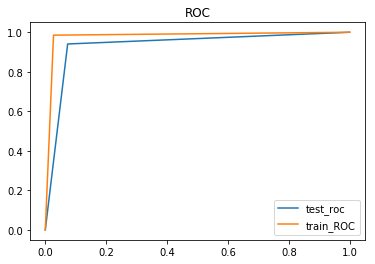

Probability density for train


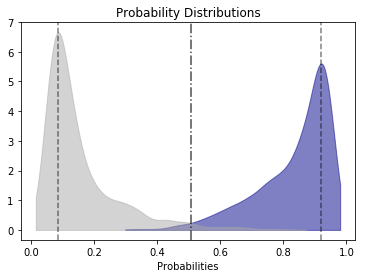

Probability density for test


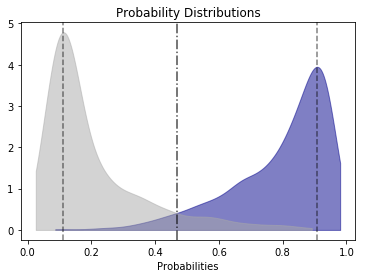


[[1059   84]
 [  60  951]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1059    84  1143
1            60   951  1011
All        1119  1035  2154


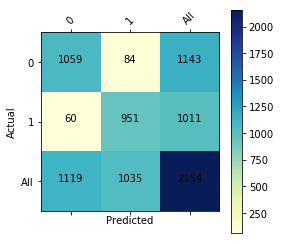


REPORT
             precision    recall  f1-score   support

          0       0.95      0.93      0.94      1143
          1       0.92      0.94      0.93      1011

avg / total       0.93      0.93      0.93      2154

ACCURACY =  0.9331476323119777
-----------------
TEST_GROUPS Counter({'4y4o.cif1_2A': 321, '6eri.cif1_AA': 295, '5xxb.cif1_1': 247, '6d9j.cif1_5': 212, '5ool.cif1_A': 164, '3jam.cif1_2': 151, '5mrc.cif1_aa': 126, '6az3.cif1_2': 83, '5t5h.cif1_B': 82, '3j7o.cif1_7': 20, '6az3.cif1_8': 20, '6d90.cif1_4': 18, '6eri.cif1_Ax': 18, '4ycp.cif1_B': 17, '5tbw.cif1_AS': 16, '2qwy.cif1_C': 13, '5wt1.cif1_C': 11, '6d9j.cif1_7': 11, '1mfq.cif1_A': 10, '3f2x.cif1_X': 10, '3iwn.cif1_A': 10, '4lck.cif1_F': 10, '4pr6.cif1_B': 10, '5axm.cif1_P': 10, '1s03.cif1_A': 9, '3dil.cif1_A': 9, '3j79.cif1_C': 9, '3jbv.cif1_W': 9, '3ski.cif1_A': 9, '3wqy.cif1_C': 9, '5aj0.cif1_Bv': 9, '5d8h.cif1_A': 9, '5t5h.cif1_C': 9, '5xy3.cif1_4': 9, '1mzp.cif1_B': 8, '1ser.cif1_T': 8, '3kfu.cif1_L': 8, '4m6

CONFUSION MATRIX By chain:  1hc8.cif1_C
[[4 0]
 [0 3]]

CONFUSION MATRIX By chain:  5id6.cif1_G
[[1]]

112 4.G.6067.4.G.6160.4.G.6172. -_-_c.H 37.55_38.89_11.29 PROBA:  0.5013174288809542
111 4.C.6181.4.G.6183.4.C.6194. cWH_cWW_- 7.68_10.55_13.46 PROBA:  0.39466921774487057
CONFUSION MATRIX By chain:  6d90.cif1_4
[[11  1]
 [ 1  5]]

100 L.U.8.L.C.11.L.A.26. -_-_- 13.34_7.29_18.16 PROBA:  0.5019604721384165
CONFUSION MATRIX By chain:  3kfu.cif1_L
[[3 1]
 [0 4]]

110 B.G.11.B.C.35.B.A.42. -_-_tSW 16.36_13.2_9.73 PROBA:  0.5581932922066328
112 B.A.10.B.G.39.B.A.42. -_-_- 6.09_8.81_13.05 PROBA:  0.5943150744155049
CONFUSION MATRIX By chain:  1mzp.cif1_B
[[3 2]
 [0 3]]

112 A.U.43.A.C.44.A.G.80. -_-_- 6.68_14.25_12.9 PROBA:  0.8792977145990339
CONFUSION MATRIX By chain:  3iwn.cif1_A
[[4 1]
 [0 5]]

CONFUSION MATRIX By chain:  5dcv.cif1_D
[[2 0]
 [0 2]]

CONFUSION MATRIX By chain:  5tbw.cif1_AS
[[9 0]
 [0 7]]

CONFUSION MATRIX By chain:  6az3.cif1_8
[[12  0]
 [ 0  8]]

112 C.U.12.C.C.13.C.G.

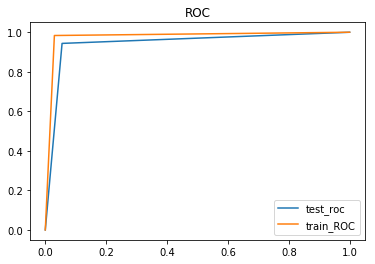

Probability density for train


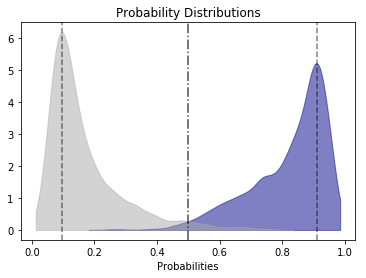

Probability density for test


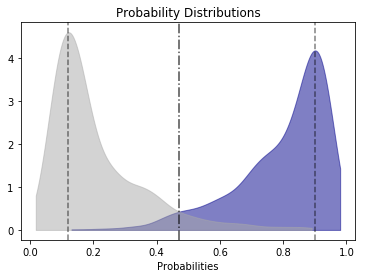


[[1080   63]
 [  57  953]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1080    63  1143
1            57   953  1010
All        1137  1016  2153


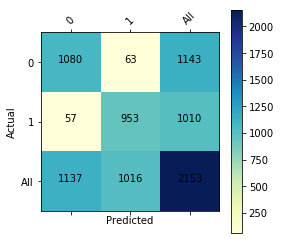


REPORT
             precision    recall  f1-score   support

          0       0.95      0.94      0.95      1143
          1       0.94      0.94      0.94      1010

avg / total       0.94      0.94      0.94      2153

ACCURACY =  0.9442638179284719
-----------------
TEST_GROUPS Counter({'5j7l.cif1_DA': 318, '6ha1.cif1_A': 295, '5tbw.cif1_1': 272, '5j7l.cif1_AA': 185, '6az1.cif1_1': 173, '5ngm.cif1_Aa': 138, '5xxu.cif1_2': 137, '6gaz.cif1_AA': 82, '5t2a.cif1_B': 78, '3igi.cif1_A': 21, '4wf9.cif1_Y': 20, '4kqy.cif1_A': 19, '6ek0.cif1_L7': 18, '5fjc.cif1_A': 17, '3ivk.cif1_M': 16, '5ccb.cif1_N': 14, '3u4m.cif1_B': 11, '5e6m.cif1_C': 11, '2der.cif1_D': 10, '4mgn.cif1_B': 10, '4qlm.cif1_A': 10, '4rdx.cif1_C': 10, '5tbw.cif1_4': 10, '6ck5.cif1_A': 10, '1b23.cif1_R': 9, '1qu2.cif1_T': 9, '2azx.cif1_D': 9, '2d6f.cif1_F': 9, '3eph.cif1_E': 9, '3rkf.cif1_C': 9, '4y1j.cif1_A': 9, '5l4o.cif1_A': 9, '6az3.cif1_3': 9, '6cfj.cif1_1x': 9, '1qtq.cif1_B': 8, '2xd0.cif1_W': 8, '3icq.cif1_E': 8, '3ox

CONFUSION MATRIX By chain:  4qk9.cif1_A
[[4 0]
 [0 4]]

CONFUSION MATRIX By chain:  3la5.cif1_A
[[4 0]
 [0 3]]

110 Aa.C.20.Aa.U.914.Aa.G.925. -_-_cWW 34.74_27.94_10.45 PROBA:  0.5857147280060588
110 Aa.C.380.Aa.U.383.Aa.A.571. -_-_- 11.19_56.71_64.12 PROBA:  0.5176943875708846
111 Aa.U.38.Aa.A.405.Aa.A.555. tWW_cHS_- 11.2_7.66_8.96 PROBA:  0.4212286005070983
111 Aa.G.148.Aa.A.174.Aa.A.1456. cWW_-_cSW 12.9_15.77_6.0 PROBA:  0.4588414463911782
111 Aa.G.216.Aa.C.223.Aa.A.474. cWW_c.H_- 11.89_9.29_13.94 PROBA:  0.395338705891599
111 Aa.G.1265.Aa.C.1269.Aa.G.1286. cSS_cWW_- 4.47_11.37_13.58 PROBA:  0.3743896649019727
CONFUSION MATRIX By chain:  5ngm.cif1_Aa
[[70  2]
 [ 4 62]]

CONFUSION MATRIX By chain:  1qtq.cif1_B
[[4 0]
 [0 4]]

111 R.4SU.8.R.A.14.R.A.46. tWH_t.W_cSS 10.04_12.76_4.86 PROBA:  0.4745949807415664
111 R.4SU.8.R.G.15.R.G.48. -_t.W_cSS 12.32_13.49_4.06 PROBA:  0.467134322347168
CONFUSION MATRIX By chain:  1b23.cif1_R
[[6 0]
 [2 1]]

123 E.U.8.E.A.10.E.G.46. -_-_- 13.81_11.58_

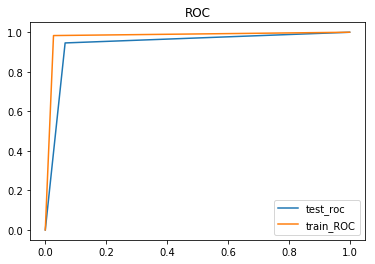

Probability density for train


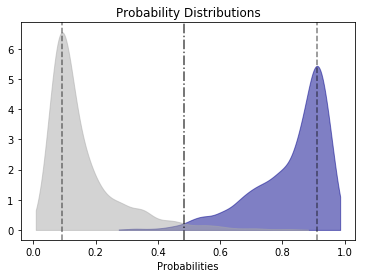

Probability density for test


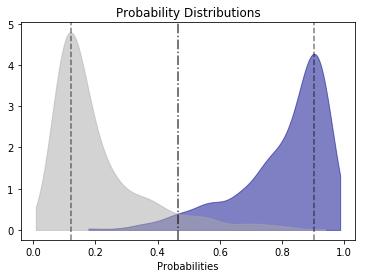


[[1062   74]
 [  55  962]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1062    74  1136
1            55   962  1017
All        1117  1036  2153


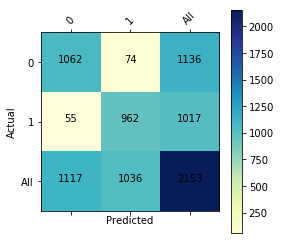


REPORT
             precision    recall  f1-score   support

          0       0.95      0.93      0.94      1136
          1       0.93      0.95      0.94      1017

avg / total       0.94      0.94      0.94      2153

ACCURACY =  0.9400836042731073
-----------------
TEST_GROUPS Counter({'5o60.cif1_A': 299, '6ek0.cif1_L5': 299, '4wf9.cif1_X': 273, '6ha1.cif1_a': 188, '4lfb.cif1_A': 173, '6eri.cif1_BA': 162, '5an9.cif1_N': 119, '5t5h.cif1_A': 102, '1u6b.cif1_B': 28, '1u9s.cif1_A': 23, '5fdv.cif1_1B': 21, '2a64.cif1_A': 20, '5ml7.cif1_B': 20, '3j79.cif1_B': 18, '4r4v.cif1_A': 18, '4yaz.cif1_R': 17, '1yfg.cif1_A': 16, '3hhn.cif1_E': 12, '4plx.cif1_A': 11, '1evv.cif1_A': 10, '1h4s.cif1_T': 10, '1il2.cif1_C': 10, '2r8s.cif1_R': 10, '3skl.cif1_B': 10, '5ool.cif1_B': 10, '1j1u.cif1_B': 9, '1n78.cif1_C': 9, '3q3z.cif1_V': 9, '4mgn.cif1_A': 9, '4v8n.cif1_CV': 9, '4wj4.cif1_B': 9, '5el4.cif1_3L': 9, '5hr6.cif1_C': 9, '5jup.cif1_EC': 9, '5xxb.cif1_4': 9, '5zwn.cif1_P': 9, '1y27.cif1_X': 8, '2

CONFUSION MATRIX By chain:  4wj4.cif1_B
[[4 0]
 [0 5]]

111 EC.A.6790.EC.C.6850.EC.G.6878. -_cWW_tSS 6.86_10.8_5.92 PROBA:  0.49690217286508415
CONFUSION MATRIX By chain:  5jup.cif1_EC
[[6 0]
 [1 2]]

112 O.A.95.O.C.96.O.C.99. -_-_- 4.83_12.14_15.69 PROBA:  0.7309970949026132
CONFUSION MATRIX By chain:  1kog.cif1_O
[[2 1]
 [0 3]]

CONFUSION MATRIX By chain:  5t5h.cif1_E
[[2 0]
 [0 1]]

CONFUSION MATRIX By chain:  2quw.cif1_B
[[2 0]
 [0 1]]

112 A.C.14.A.G.19.A.G.30. -_-_cWW 13.8_4.49_10.83 PROBA:  0.7671194291974957
111 A.C.15.A.G.19.A.A.39. cWW_t.W_cSW 10.7_12.97_5.54 PROBA:  0.460199711330717
CONFUSION MATRIX By chain:  4oji.cif1_A
[[1 1]
 [1 1]]

111 A.C.103.A.C.150.A.A.171. -_tWH_tSW 8.96_11.45_8.9 PROBA:  0.22879954318297543
111 A.G.575.A.G.576.A.C.880. cSH_-_cWW 6.64_9.58_10.22 PROBA:  0.48894855706257273
111 A.A.676.A.G.714.A.A.777. cWW_tSS_- 13.0_4.56_11.19 PROBA:  0.47213993788254366
111 A.G.1124.A.C.1149.A.A.1280. cWW_cSW_- 11.12_9.33_12.37 PROBA:  0.4838386644043144
111 A.G.

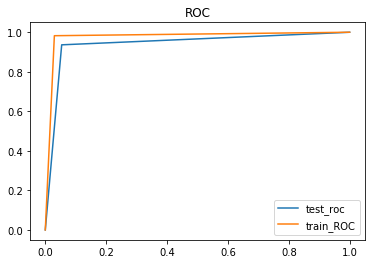

Probability density for train


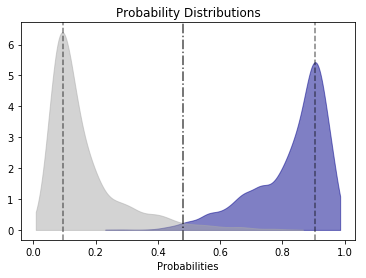

Probability density for test


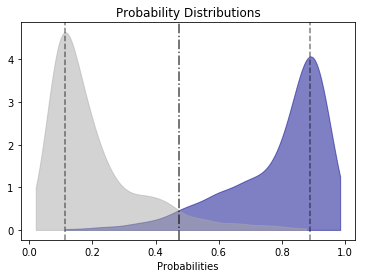


[[1071   61]
 [  65  956]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1071    61  1132
1            65   956  1021
All        1136  1017  2153


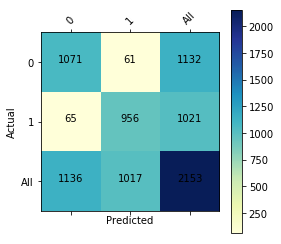


REPORT
             precision    recall  f1-score   support

          0       0.94      0.95      0.94      1132
          1       0.94      0.94      0.94      1021

avg / total       0.94      0.94      0.94      2153

ACCURACY =  0.9414770088248955
-----------------


In [8]:
groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=5)
#group_kfold.get_n_splits(X, y, groups)

description = ['type', 'dssrs', 'bps', 'dists']

for train_index, test_index in group_kfold.split(triplexes, triplexes_target, groups):
    #triplexes_data = triplexes.iloc[:, 5:475]
    #print(triplexes_data)
    X_train_middle, X_test_middle = triplexes.loc[list(train_index)], triplexes.loc[test_index]
    X_train = X_train_middle.iloc[:, 5:475]
    X_test = X_test_middle.iloc[:, 5:475]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]

    
    a = Counter(list(triplexes.loc[list(train_index)].pdb_chain.values))
    b = Counter(list(triplexes.loc[list(test_index)].pdb_chain.values))
    
    for key in a:
        if key in b.keys():
            print("FUUUUUUUUU")
    print("TEST_GROUPS", Counter(list(triplexes.pdb_chain.loc[test_index])))
    rf_classifier_cv.fit(X_train, y_train)
    
    #prediction by chains
    chains = list(set(X_test_middle.pdb_chain.values))

    print("")
    for chain in chains:
        middle_check_test = X_test_middle.loc[X_test_middle['pdb_chain'] == chain]
        middle_target_test = middle_check_test['istriple']
        middle_check_test_ = middle_check_test.iloc[:, 5:475]
    
        prediction_result_by_chain = rf_classifier_cv.predict(middle_check_test_)
        predict_proba_by_chain = rf_classifier_cv.predict_proba(middle_check_test_)

        
        #PREDICTED PROBABILITIES
        i = 0
        for index, row in middle_check_test.iterrows():
            if middle_target_test[index] != prediction_result_by_chain[i]:
                print(row['type'], row['dssrs'], row['bps'], row['dists'], "PROBA: ", predict_proba_by_chain[i][1])
            i = i + 1

        print("CONFUSION MATRIX By chain: ", chain)
        print(confusion_matrix(middle_target_test, prediction_result_by_chain))
        print("")
    
    #simple prediction
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_train)
    auc_train = metrics.roc_auc_score(y_train, prediction_train)
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_result)
    auc = metrics.roc_auc_score(y_test, prediction_result)
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))


    print("")
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY = ", accuracy_score(y_test, prediction_result))
    print("-----------------")



AUC_TRAIN =  0.9760040589829944

AUC =  0.9378022243713733


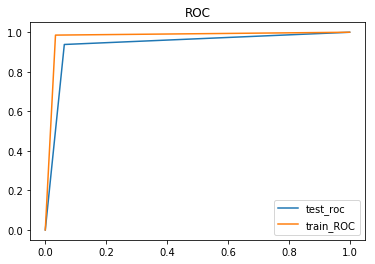

Probability density for train


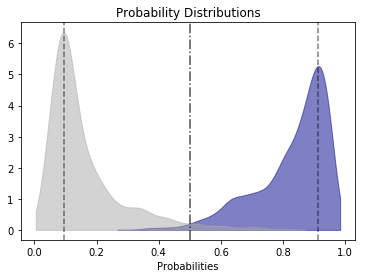

Probability density for test


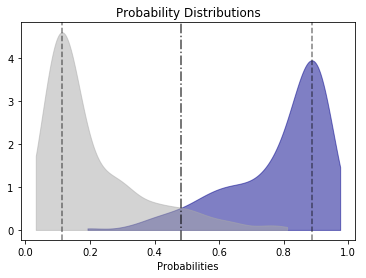


[[525  35]
 [ 32 485]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          525   35   560
1           32  485   517
All        557  520  1077


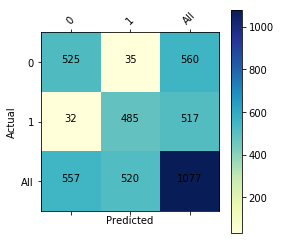

REPORT
             precision    recall  f1-score   support

          0       0.94      0.94      0.94       560
          1       0.93      0.94      0.94       517

avg / total       0.94      0.94      0.94      1077

ACCURACY 0.9377901578458682
-----------------

AUC_TRAIN =  0.9780513450698581

AUC =  0.935051122056504


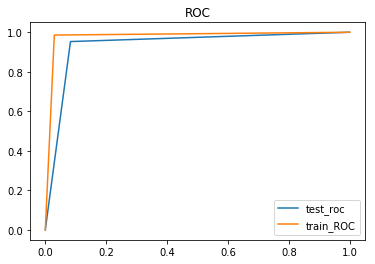

Probability density for train


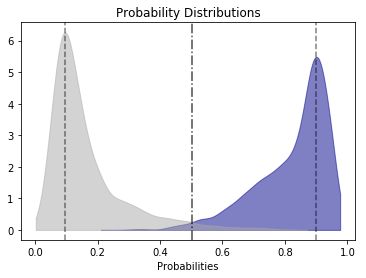

Probability density for test


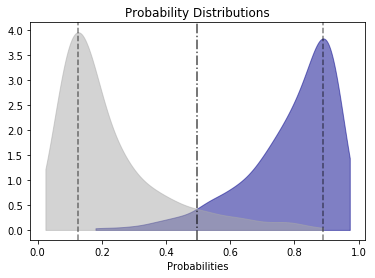


[[521  47]
 [ 24 485]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          521   47   568
1           24  485   509
All        545  532  1077


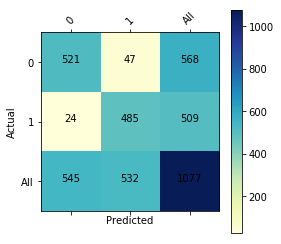

REPORT
             precision    recall  f1-score   support

          0       0.96      0.92      0.94       568
          1       0.91      0.95      0.93       509

avg / total       0.94      0.93      0.93      1077

ACCURACY 0.9340761374187558
-----------------

AUC_TRAIN =  0.9772337794931517

AUC =  0.9436603144057646


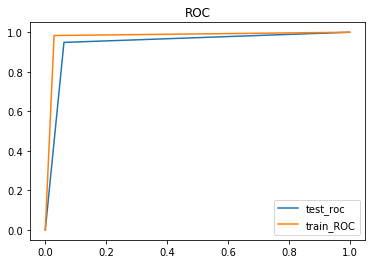

Probability density for train


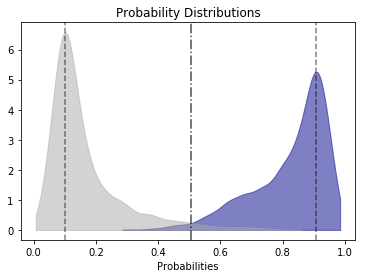

Probability density for test


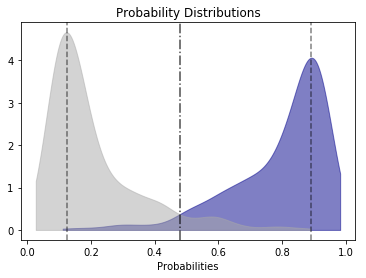


[[536  35]
 [ 26 480]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          536   35   571
1           26  480   506
All        562  515  1077


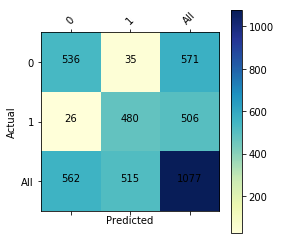

REPORT
             precision    recall  f1-score   support

          0       0.95      0.94      0.95       571
          1       0.93      0.95      0.94       506

avg / total       0.94      0.94      0.94      1077

ACCURACY 0.9433611884865367
-----------------

AUC_TRAIN =  0.9755518300604346

AUC =  0.9397176372884875


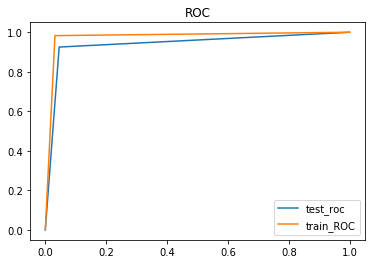

Probability density for train


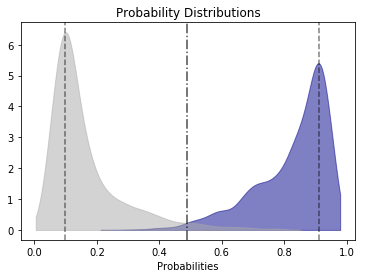

Probability density for test


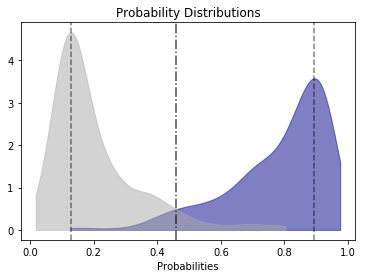


[[544  26]
 [ 38 469]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          544   26   570
1           38  469   507
All        582  495  1077


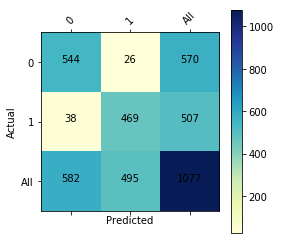

REPORT
             precision    recall  f1-score   support

          0       0.93      0.95      0.94       570
          1       0.95      0.93      0.94       507

avg / total       0.94      0.94      0.94      1077

ACCURACY 0.9405756731662024
-----------------

AUC_TRAIN =  0.9761902767182

AUC =  0.9295310716879345


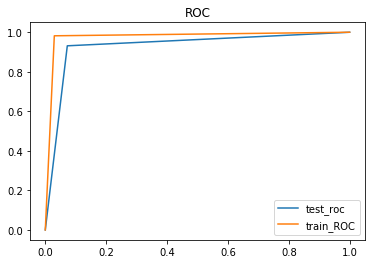

Probability density for train


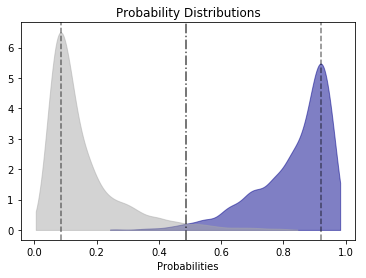

Probability density for test


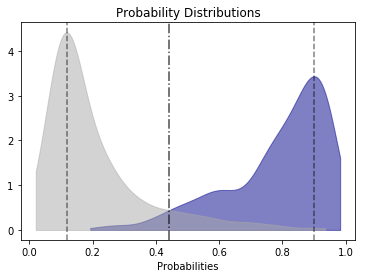


[[526  41]
 [ 35 475]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          526   41   567
1           35  475   510
All        561  516  1077


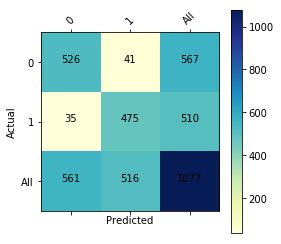

REPORT
             precision    recall  f1-score   support

          0       0.94      0.93      0.93       567
          1       0.92      0.93      0.93       510

avg / total       0.93      0.93      0.93      1077

ACCURACY 0.9294336118848654
-----------------

AUC_TRAIN =  0.9751620757959418

AUC =  0.9544381361213043


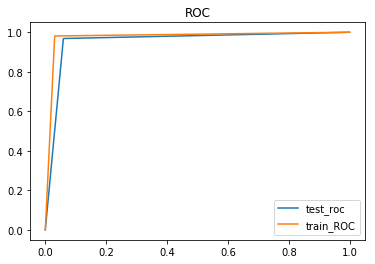

Probability density for train


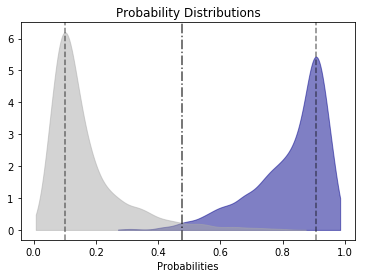

Probability density for test


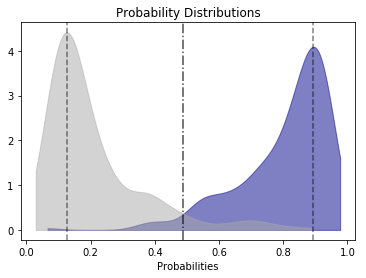


[[538  34]
 [ 16 489]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          538   34   572
1           16  489   505
All        554  523  1077


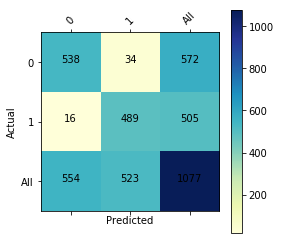

REPORT
             precision    recall  f1-score   support

          0       0.97      0.94      0.96       572
          1       0.93      0.97      0.95       505

avg / total       0.95      0.95      0.95      1077

ACCURACY 0.9535747446610956
-----------------

AUC_TRAIN =  0.9756516160844868

AUC =  0.9485475671750182


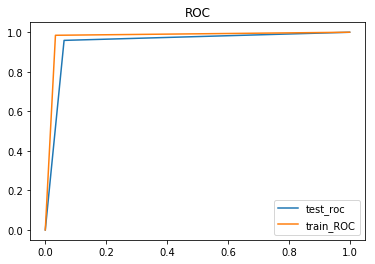

Probability density for train


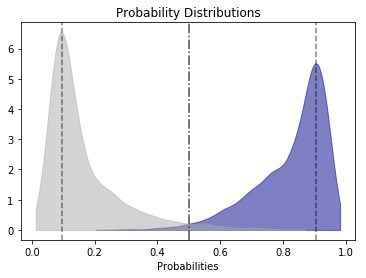

Probability density for test


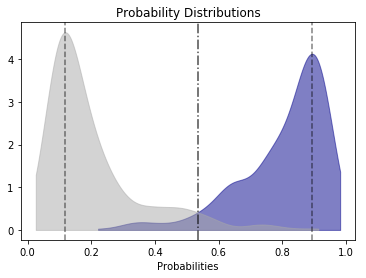


[[532  35]
 [ 21 489]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          532   35   567
1           21  489   510
All        553  524  1077


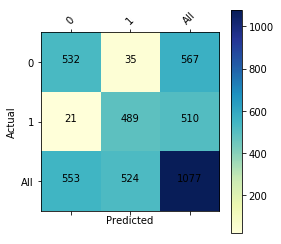

REPORT
             precision    recall  f1-score   support

          0       0.96      0.94      0.95       567
          1       0.93      0.96      0.95       510

avg / total       0.95      0.95      0.95      1077

ACCURACY 0.9480037140204272
-----------------

AUC_TRAIN =  0.9752123876086997

AUC =  0.9478365009112212


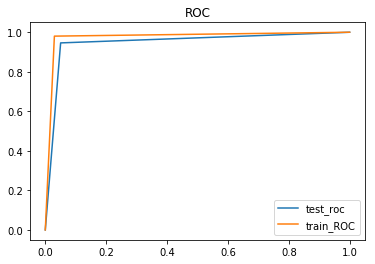

Probability density for train


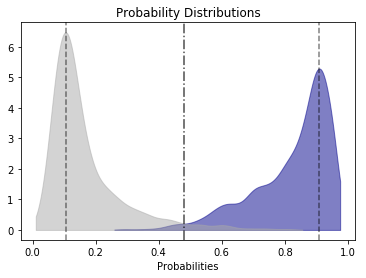

Probability density for test


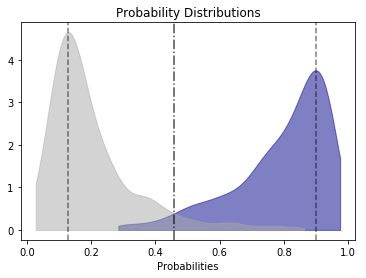


[[546  29]
 [ 27 474]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          546   29   575
1           27  474   501
All        573  503  1076


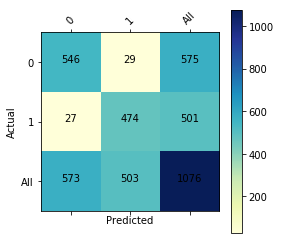

REPORT
             precision    recall  f1-score   support

          0       0.95      0.95      0.95       575
          1       0.94      0.95      0.94       501

avg / total       0.95      0.95      0.95      1076

ACCURACY 0.9479553903345725
-----------------

AUC_TRAIN =  0.9782716507857414

AUC =  0.9340737968766785


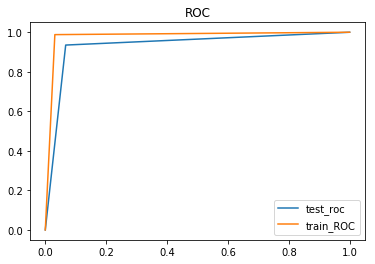

Probability density for train


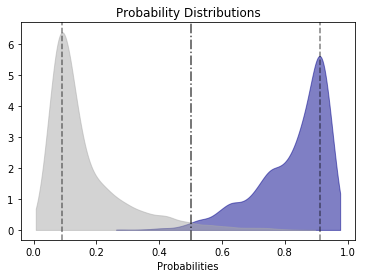

Probability density for test


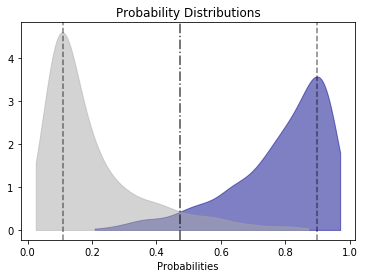


[[529  38]
 [ 33 476]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          529   38   567
1           33  476   509
All        562  514  1076


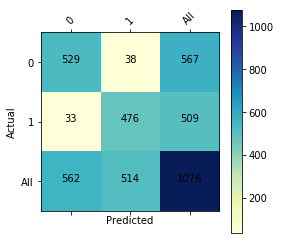

REPORT
             precision    recall  f1-score   support

          0       0.94      0.93      0.94       567
          1       0.93      0.94      0.93       509

avg / total       0.93      0.93      0.93      1076

ACCURACY 0.9340148698884758
-----------------

AUC_TRAIN =  0.9767188070253574

AUC =  0.949486111111111


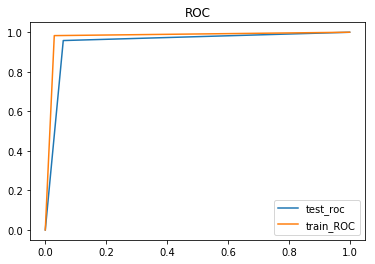

Probability density for train


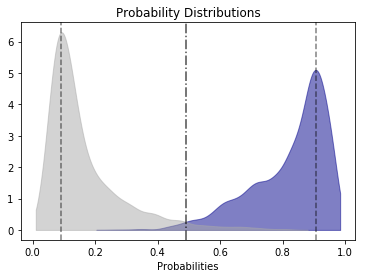

Probability density for test


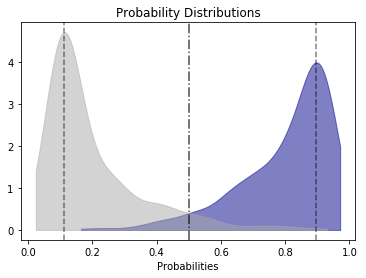


[[542  34]
 [ 21 479]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          542   34   576
1           21  479   500
All        563  513  1076


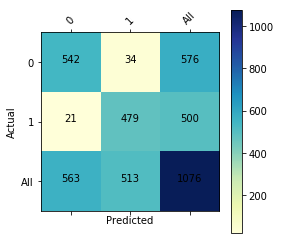

REPORT
             precision    recall  f1-score   support

          0       0.96      0.94      0.95       576
          1       0.93      0.96      0.95       500

avg / total       0.95      0.95      0.95      1076

ACCURACY 0.9488847583643123
-----------------


In [9]:
# 10 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=10)
#group_kfold.get_n_splits(X, y, groups)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_train)
    auc_train = metrics.roc_auc_score(y_train, prediction_train)
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_result)
    auc = metrics.roc_auc_score(y_test, prediction_result)
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))
    
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")



AUC_TRAIN =  0.9762133775061314

AUC =  0.9135358535503304


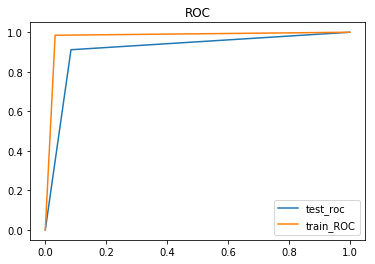

Probability density for train


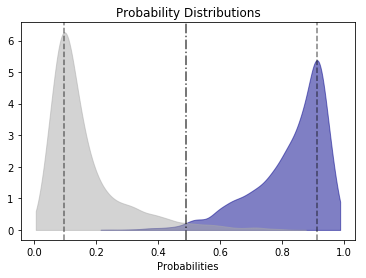

Probability density for test


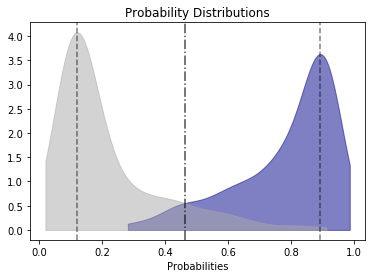


[[347  32]
 [ 30 309]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          347   32  379
1           30  309  339
All        377  341  718


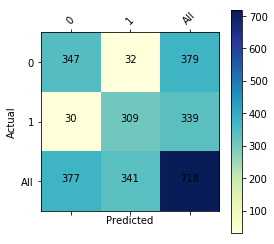

REPORT
             precision    recall  f1-score   support

          0       0.92      0.92      0.92       379
          1       0.91      0.91      0.91       339

avg / total       0.91      0.91      0.91       718

ACCURACY 0.9136490250696379
-----------------

AUC_TRAIN =  0.9774647172447037

AUC =  0.9485519922254616


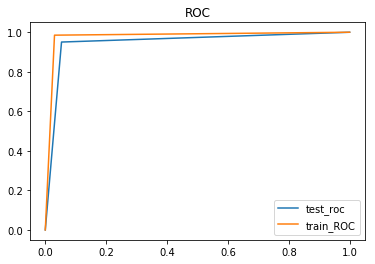

Probability density for train


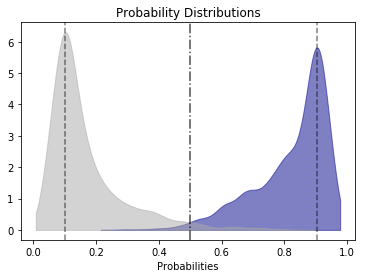

Probability density for test


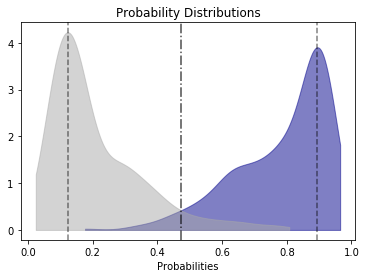


[[355  20]
 [ 17 326]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          355   20  375
1           17  326  343
All        372  346  718


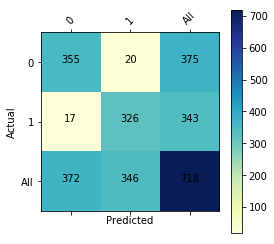

REPORT
             precision    recall  f1-score   support

          0       0.95      0.95      0.95       375
          1       0.94      0.95      0.95       343

avg / total       0.95      0.95      0.95       718

ACCURACY 0.9484679665738162
-----------------

AUC_TRAIN =  0.9744531085074941

AUC =  0.9550924087011378


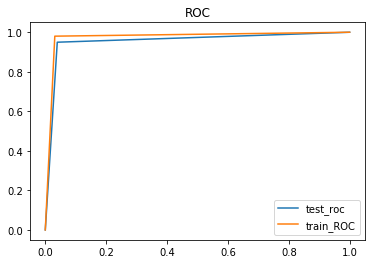

Probability density for train


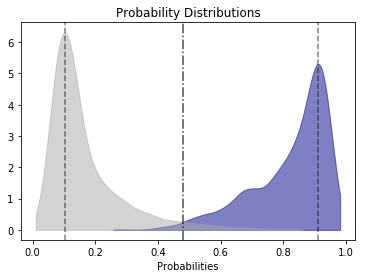

Probability density for test


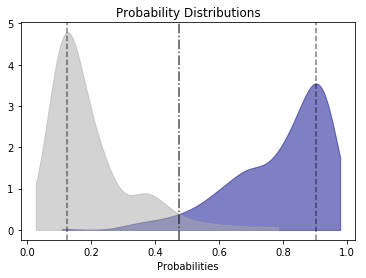


[[366  15]
 [ 17 320]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          366   15  381
1           17  320  337
All        383  335  718


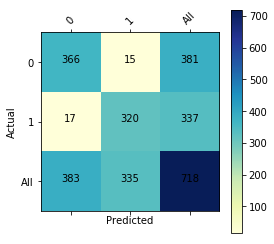

REPORT
             precision    recall  f1-score   support

          0       0.96      0.96      0.96       381
          1       0.96      0.95      0.95       337

avg / total       0.96      0.96      0.96       718

ACCURACY 0.9554317548746518
-----------------

AUC_TRAIN =  0.9745711843513879

AUC =  0.9440182135728543


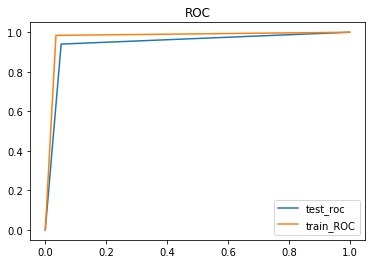

Probability density for train


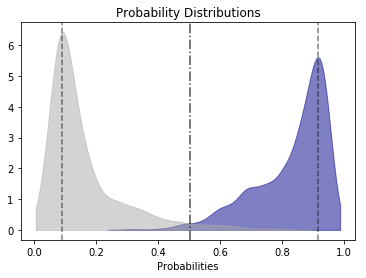

Probability density for test


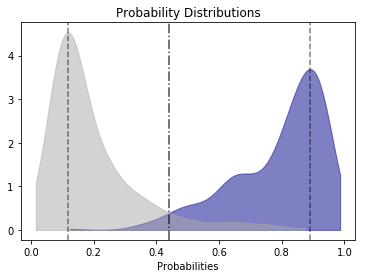


[[364  20]
 [ 20 314]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          364   20  384
1           20  314  334
All        384  334  718


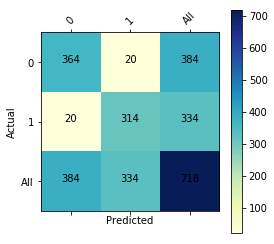

REPORT
             precision    recall  f1-score   support

          0       0.95      0.95      0.95       384
          1       0.94      0.94      0.94       334

avg / total       0.94      0.94      0.94       718

ACCURACY 0.9442896935933147
-----------------

AUC_TRAIN =  0.9749082638009269

AUC =  0.9472204920585487


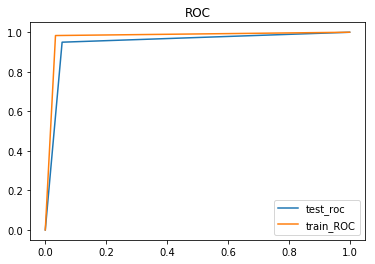

Probability density for train


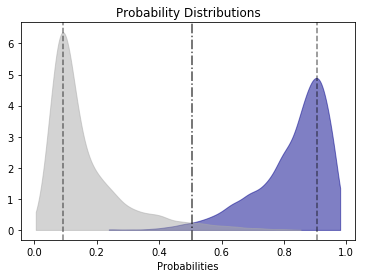

Probability density for test


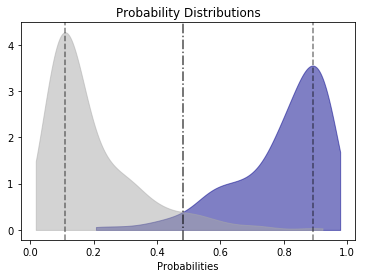


[[359  21]
 [ 17 321]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          359   21  380
1           17  321  338
All        376  342  718


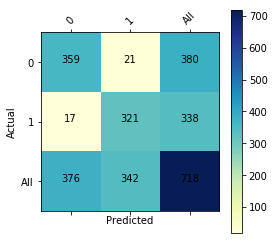

REPORT
             precision    recall  f1-score   support

          0       0.95      0.94      0.95       380
          1       0.94      0.95      0.94       338

avg / total       0.95      0.95      0.95       718

ACCURACY 0.947075208913649
-----------------

AUC_TRAIN =  0.9751261089576307

AUC =  0.9458969168483338


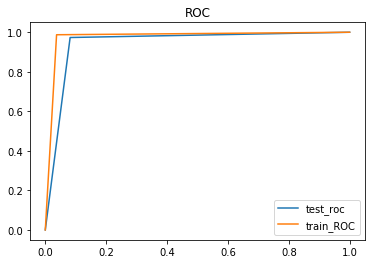

Probability density for train


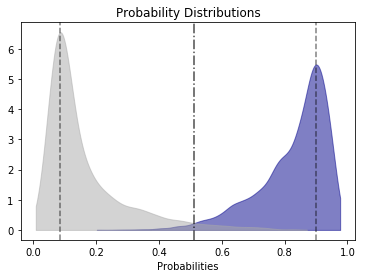

Probability density for test


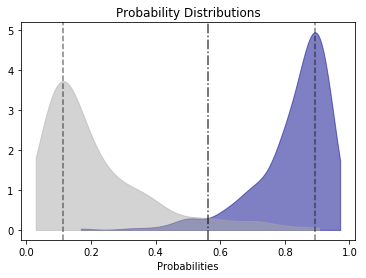


[[349  31]
 [  9 329]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          349   31  380
1            9  329  338
All        358  360  718


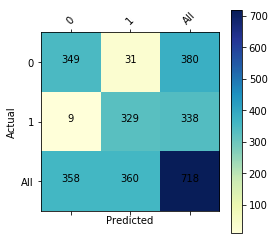

REPORT
             precision    recall  f1-score   support

          0       0.97      0.92      0.95       380
          1       0.91      0.97      0.94       338

avg / total       0.95      0.94      0.94       718

ACCURACY 0.9442896935933147
-----------------

AUC_TRAIN =  0.9752890461150318

AUC =  0.9336990351696234


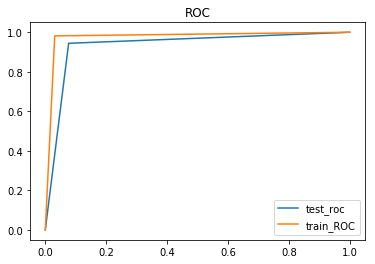

Probability density for train


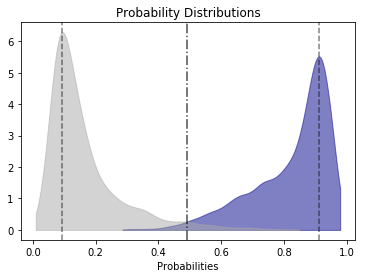

Probability density for test


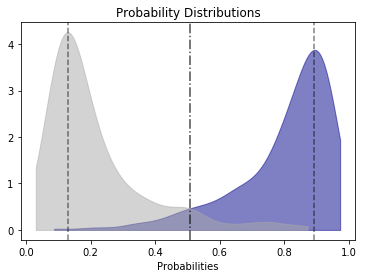


[[349  29]
 [ 19 321]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          349   29  378
1           19  321  340
All        368  350  718


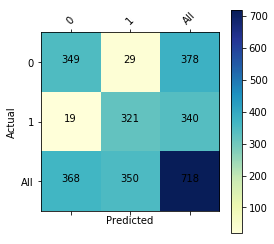

REPORT
             precision    recall  f1-score   support

          0       0.95      0.92      0.94       378
          1       0.92      0.94      0.93       340

avg / total       0.93      0.93      0.93       718

ACCURACY 0.9331476323119777
-----------------

AUC_TRAIN =  0.9753600283929111

AUC =  0.9451680672268908


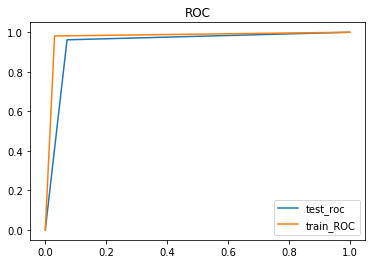

Probability density for train


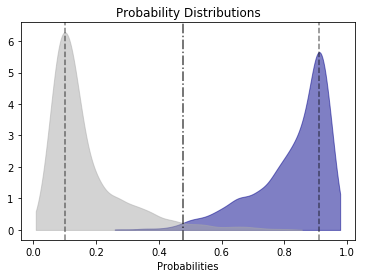

Probability density for test


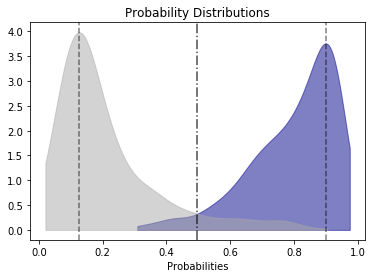


[[351  27]
 [ 13 327]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          351   27  378
1           13  327  340
All        364  354  718


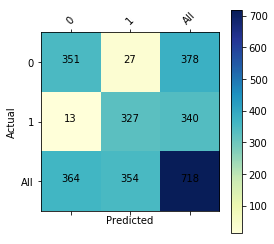

REPORT
             precision    recall  f1-score   support

          0       0.96      0.93      0.95       378
          1       0.92      0.96      0.94       340

avg / total       0.95      0.94      0.94       718

ACCURACY 0.9442896935933147
-----------------

AUC_TRAIN =  0.9735334130714566

AUC =  0.932591093117409


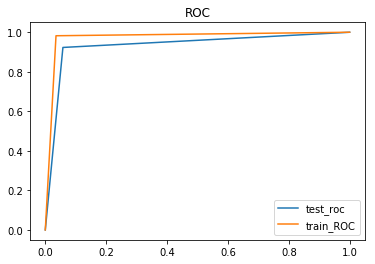

Probability density for train


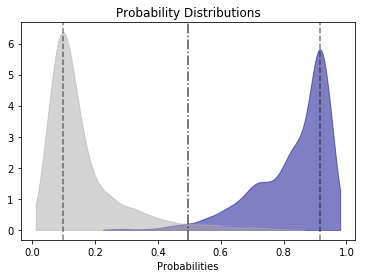

Probability density for test


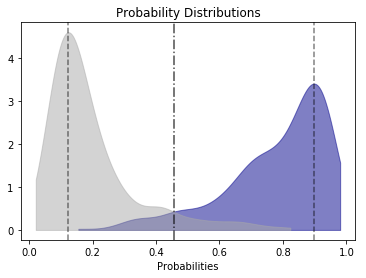


[[358  22]
 [ 26 312]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          358   22  380
1           26  312  338
All        384  334  718


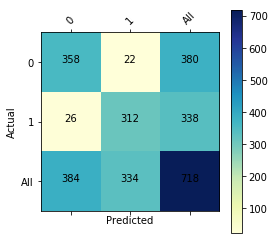

REPORT
             precision    recall  f1-score   support

          0       0.93      0.94      0.94       380
          1       0.93      0.92      0.93       338

avg / total       0.93      0.93      0.93       718

ACCURACY 0.9331476323119777
-----------------

AUC_TRAIN =  0.9742609121665738

AUC =  0.9360274869109948


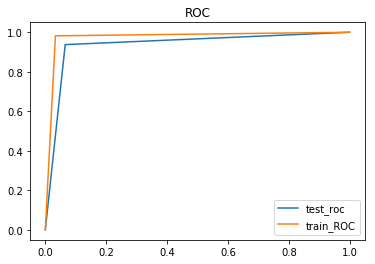

Probability density for train


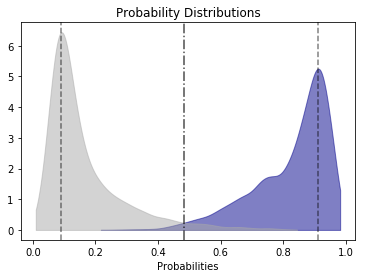

Probability density for test


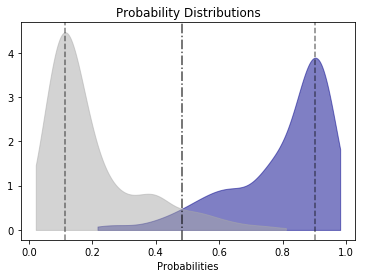


[[357  25]
 [ 21 315]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          357   25  382
1           21  315  336
All        378  340  718


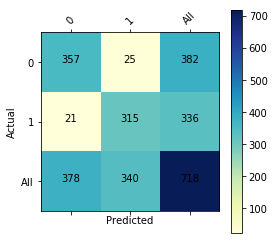

REPORT
             precision    recall  f1-score   support

          0       0.94      0.93      0.94       382
          1       0.93      0.94      0.93       336

avg / total       0.94      0.94      0.94       718

ACCURACY 0.935933147632312
-----------------

AUC_TRAIN =  0.9740980658100225

AUC =  0.9429461227032078


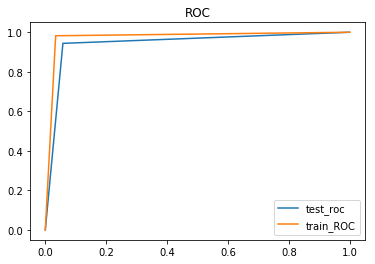

Probability density for train


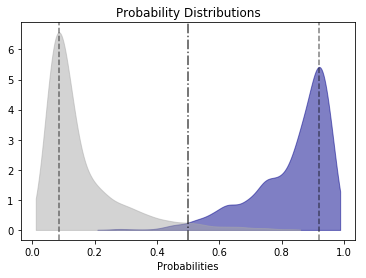

Probability density for test


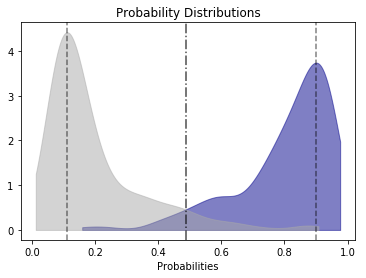


[[358  22]
 [ 19 319]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          358   22  380
1           19  319  338
All        377  341  718


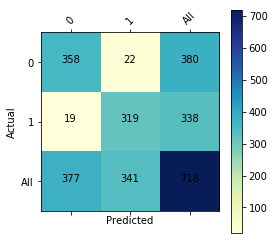

REPORT
             precision    recall  f1-score   support

          0       0.95      0.94      0.95       380
          1       0.94      0.94      0.94       338

avg / total       0.94      0.94      0.94       718

ACCURACY 0.9428969359331476
-----------------

AUC_TRAIN =  0.976243206534158

AUC =  0.943288768386936


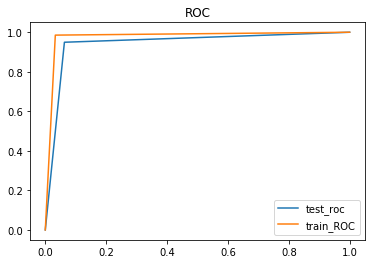

Probability density for train


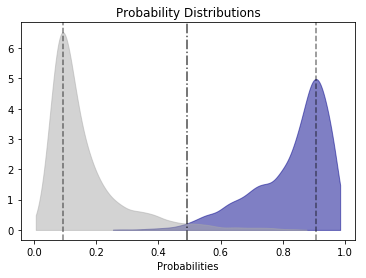

Probability density for test


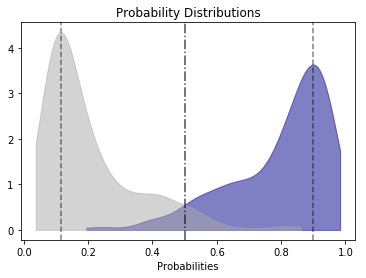


[[358  24]
 [ 17 319]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          358   24  382
1           17  319  336
All        375  343  718


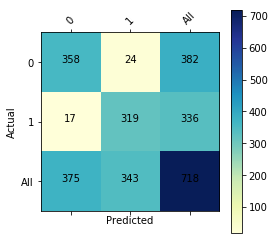

REPORT
             precision    recall  f1-score   support

          0       0.95      0.94      0.95       382
          1       0.93      0.95      0.94       336

avg / total       0.94      0.94      0.94       718

ACCURACY 0.9428969359331476
-----------------

AUC_TRAIN =  0.9761600439069561

AUC =  0.9443516929318148


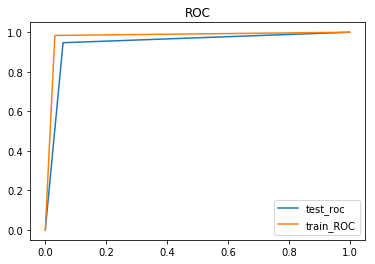

Probability density for train


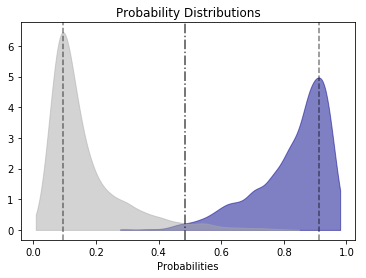

Probability density for test


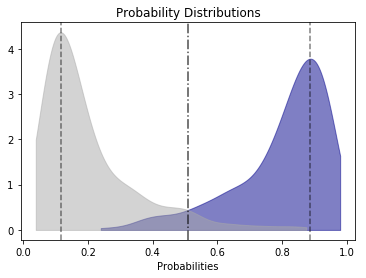


[[355  22]
 [ 18 322]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          355   22  377
1           18  322  340
All        373  344  717


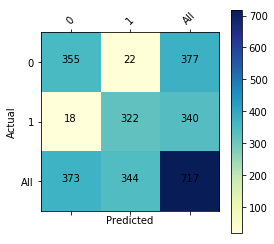

REPORT
             precision    recall  f1-score   support

          0       0.95      0.94      0.95       377
          1       0.94      0.95      0.94       340

avg / total       0.94      0.94      0.94       717

ACCURACY 0.9442119944211994
-----------------

AUC_TRAIN =  0.975914116315287

AUC =  0.937576064908722


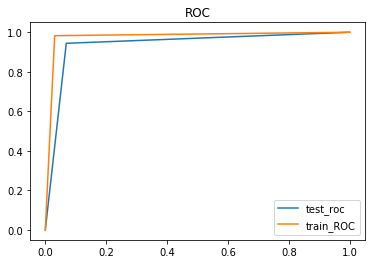

Probability density for train


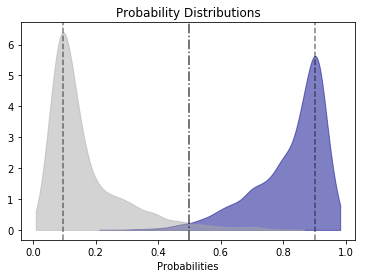

Probability density for test


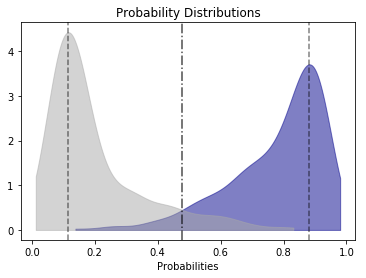


[[351  26]
 [ 19 321]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          351   26  377
1           19  321  340
All        370  347  717


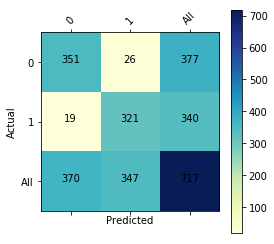

REPORT
             precision    recall  f1-score   support

          0       0.95      0.93      0.94       377
          1       0.93      0.94      0.93       340

avg / total       0.94      0.94      0.94       717

ACCURACY 0.9372384937238494
-----------------

AUC_TRAIN =  0.9789286903310638

AUC =  0.9318327346556301


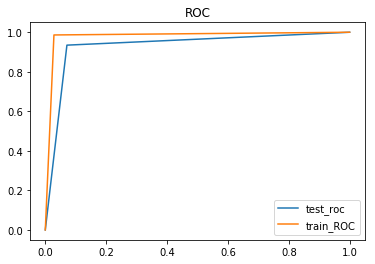

Probability density for train


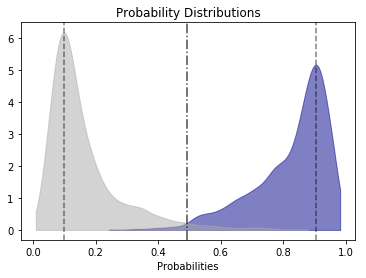

Probability density for test


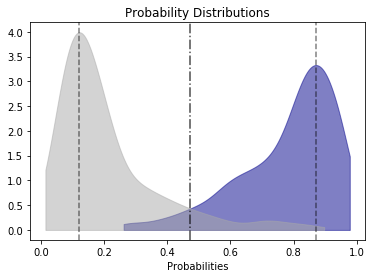


[[353  27]
 [ 22 315]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          353   27  380
1           22  315  337
All        375  342  717


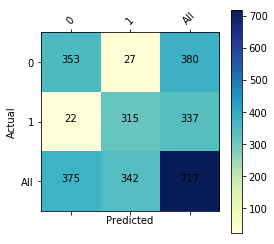

REPORT
             precision    recall  f1-score   support

          0       0.94      0.93      0.94       380
          1       0.92      0.93      0.93       337

avg / total       0.93      0.93      0.93       717

ACCURACY 0.9316596931659693
-----------------


In [10]:
# 15 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=15)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_train)
    auc_train = metrics.roc_auc_score(y_train, prediction_train)
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_result)
    auc = metrics.roc_auc_score(y_test, prediction_result)
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))
    
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")
